<a href="https://colab.research.google.com/github/SuhasJainG/Credit-Card-Fraud-detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #don't know
import seaborn as sns
sns.set(style="whitegrid")
import random
import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
from pylab import rcParams
rcParams['figure.figsize']=14,8
LABELS=["Normal","Fraud"]
import plotly
import time

#classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#other libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline 
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report
from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



Mounted at /content/drive


# Data exploration


1.Loading the dataset

In [17]:
df=pd.read_csv('/content/drive/My Drive/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features are already scaled and names are not shown.
 Now, let's have a look at how many of the transactions are fraudulent.

In [18]:
#loc locates all data by column or conditional statements
frauds=df.loc[df['Class']==1] #find all rows that are fraudulant
non_frauds=df.loc[df['Class']==0] #find all rows that are not fraudulant
print('Frauds',len(frauds),'transactions or',round(df['Class'].value_counts()[1]/len(df)*100,2),'% of dataset')
print('No fraud',len(non_frauds),'transactions or',round(df['Class'].value_counts()[0]/len(df)*100,2),'% of dataset')

Frauds 492 transactions or 0.17 % of dataset
No fraud 284315 transactions or 99.83 % of dataset


In [19]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [20]:
df.isnull().sum().max()

0

# Visualising the data

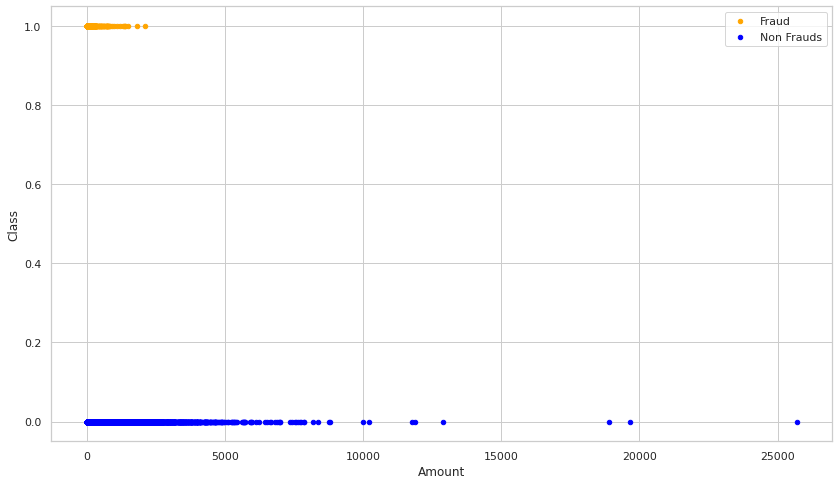

In [21]:
ax=frauds.plot.scatter(x='Amount',y='Class',color='Orange',label='Fraud')
non_frauds.plot.scatter(x="Amount",y='Class',color='Blue',label='Non Frauds',ax=ax)
plt.show()

# Visualising with seaborn

Text(0.5, 1.0, 'Class distribution \n (0:No fraud || 1:Fraud)')

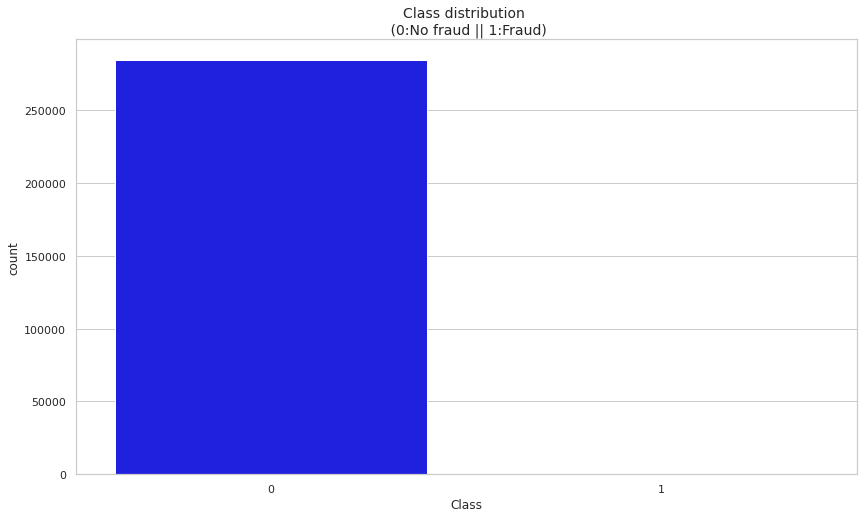

In [22]:
colors=['Blue','Orange']
sns.countplot('Class',data=df,palette=colors)
plt.title("Class distribution \n (0:No fraud || 1:Fraud)",fontsize=14)

# Distribution

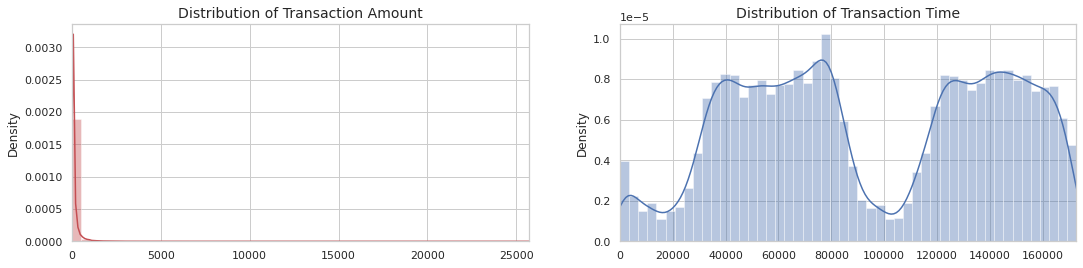

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# Scaling and Distribution

In [24]:
from sklearn.preprocessing import StandardScaler,RobustScaler

std_scaler=StandardScaler()
rob_scaler=RobustScaler()

df['scaled_amount']=rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time']=rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount','Time'],axis=1,inplace=True)

In [25]:
scaled_amount=df['scaled_amount']
scaled_time=df['scaled_time']

df.drop(['scaled_amount','scaled_time'],axis=1,inplace=True)
df.insert(0,'scaled_amount',scaled_amount)
df.insert(1,'scaled_time',scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the data


In [26]:
print('No frauds',round(df['Class'].value_counts()[0]/len(df)*100,2),'% of the dataset')
print('Frauds',round(df['Class'].value_counts()[1]/len(df)*100,2),'% of the dataset')

X=df.drop('Class',axis=1)
y=df['Class']

skf=StratifiedKFold(n_splits=5,random_state=None,shuffle=False)

for train_index,test_index in skf.split(X,y):
  print('Train:',train_index,'Test:',test_index)
  original_X_train,original_X_test=X.iloc[train_index],X.iloc[test_index]
  original_y_train,original_y_test=y.iloc[train_index],y.iloc[test_index]

original_X_train=original_X_train.values
original_X_test=original_X_test.values
original_y_train=original_y_train.values
original_y_test=original_y_test.values



No frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


# Random undersampling and oversampling


In [27]:
df=df.sample(frac=1)

fraud_df=df.loc[df['Class']==1]
non_fraud_df=df.loc[df['Class']==0][:492]

normal_distributed_df=pd.concat([fraud_df,non_fraud_df])

new_df=normal_distributed_df.sample(frac=1,random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
146511,-0.293440,0.035785,-2.906187,2.617046,-1.441588,-3.012439,-0.081472,-0.888518,0.088023,1.285286,0.479797,0.113791,-0.322673,1.142599,0.398901,0.778669,-1.184108,0.971016,-0.955819,-0.051657,-0.348592,0.410914,-0.340836,-0.960193,-0.039751,-1.047557,0.403331,0.447749,0.475436,0.322843,0
234632,-0.285195,0.744381,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,-2.748496,-3.202436,1.991361,-3.986416,0.577207,-8.485795,-0.794782,-0.666134,-1.372629,-0.104313,-1.466911,0.313332,0.209086,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1
117351,2.207783,-0.118058,0.702117,-1.068872,1.863822,1.848106,-1.709100,1.019912,-1.151187,0.512488,1.662102,-0.295569,0.118193,1.242608,-0.596741,-0.912500,-2.095318,-0.151070,0.017129,0.627497,0.270488,0.171797,0.233606,0.766906,-0.316457,0.389201,0.475801,-0.132825,0.084189,0.060320,0
221018,4.164186,0.677898,-3.367770,0.099249,-6.148487,3.401955,0.458307,-1.571630,-1.358708,0.672409,-3.188001,-4.937427,3.723933,-4.603176,1.019180,-6.619090,-0.590224,-4.472548,-7.165044,-1.581128,1.930380,0.264699,0.861308,1.249301,1.850627,-0.117471,1.219815,0.000251,1.036011,0.004367,1
276071,-0.028645,0.965601,2.091900,-0.757459,-1.192258,-0.755458,-0.620324,-0.322077,-1.082511,0.117200,-0.140927,0.249311,1.338318,-0.329759,-0.363591,-1.824839,-0.229679,1.842347,1.194212,0.037467,0.423099,0.037438,0.288253,0.831939,0.142007,0.592615,-0.196143,-0.136676,0.020182,-0.015470,1


# Equally distibuting and correlating

Distribution of the classes in subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


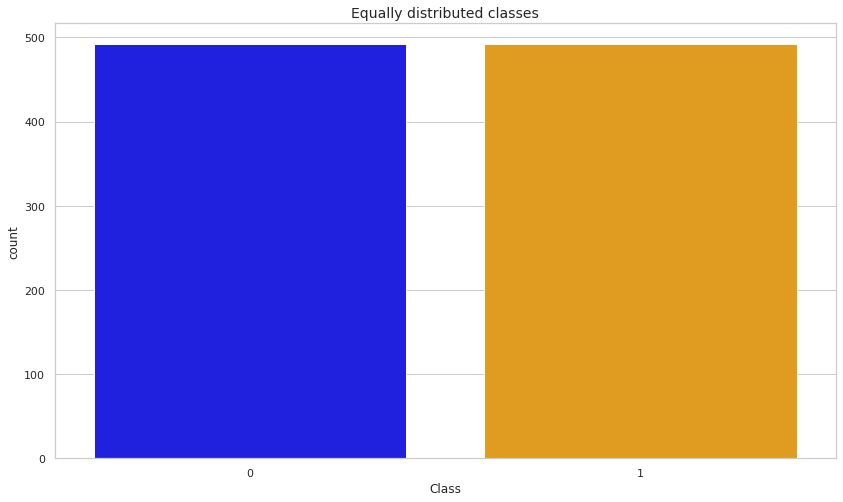

In [28]:
print('Distribution of the classes in subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class',data=new_df,palette=colors)
plt.title('Equally distributed classes',fontsize=14)
plt.show()

# Correlation matrices

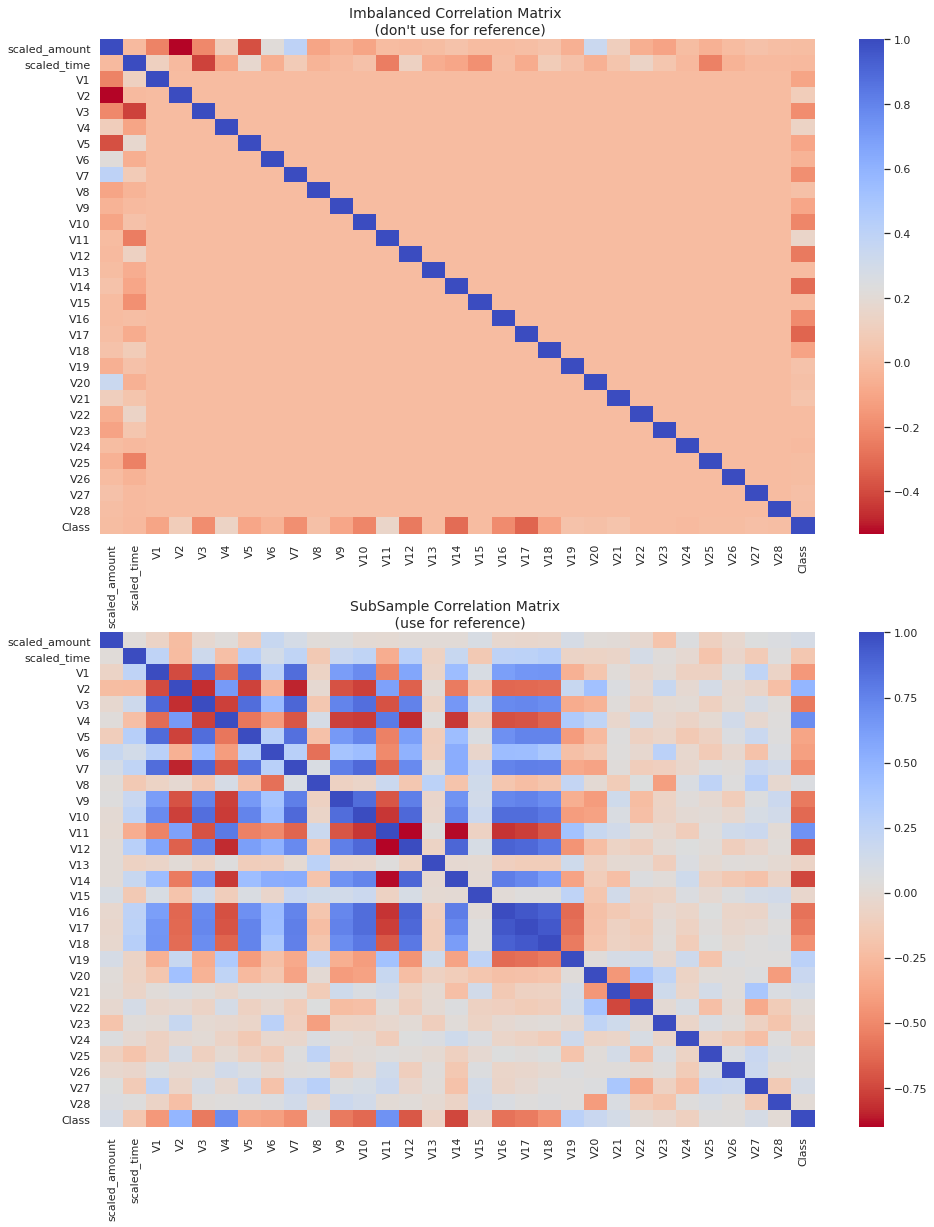

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Entire DataFrame (to show how the correlation looks like in an imbalanced dataset)
corr = df.corr() # calculate correlation between features
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr() # calculate correlation between features
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

In [30]:
sol=(sub_sample_corr.where(np.triu(np.ones(sub_sample_corr.shape),k=1).astype(np.bool))
    .stack()
    .sort_values(ascending=False))

print(sol[0:9])
print(sol[-9:-1])

V16  V17    0.953991
V17  V18    0.943753
V16  V18    0.908959
V12  V16    0.899226
V3   V7     0.883627
V12  V14    0.881774
V10  V12    0.880736
V12  V17    0.876977
V1   V3     0.873080
dtype: float64
V4   V10   -0.783406
     V14   -0.795407
V10  V11   -0.797085
V11  V16   -0.806701
V2   V3    -0.824578
V4   V12   -0.833042
V2   V7    -0.846411
V11  V14   -0.889920
dtype: float64


In [31]:
print(sub_sample_corr['Class'].sort_values(ascending=False))

Class            1.000000
V4               0.709487
V11              0.682786
V2               0.485196
V19              0.267406
V20              0.190548
V21              0.123359
V27              0.106069
scaled_amount    0.103513
V8               0.066110
V25              0.044567
V26              0.042087
V22              0.014788
V28              0.012666
V23             -0.018784
V15             -0.038530
V13             -0.066539
V24             -0.095324
scaled_time     -0.171351
V5              -0.371648
V6              -0.393363
V1              -0.425639
V18             -0.467924
V7              -0.480567
V17             -0.557777
V3              -0.565146
V9              -0.565873
V16             -0.594271
V10             -0.628063
V12             -0.686095
V14             -0.747257
Name: Class, dtype: float64
